# Importing Libraries

In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import random
import statsmodels.api as sm
import matplotlib.pyplot as plt
import sys
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import itertools

sys.path.append('../src')

from data_management import load_data, preprocess_data, train_data_split, undo_scaling
from model_training import define_model_lstm, train_model, define_model_gru, set_random_seed,define_model_cnn
from model_evaluation import score_model, grid_search, pred_test, actual_predict_plot, war_no_war_plot

%load_ext autoreload
%autoreload 2

# Analysis of Target Column 'GDP' Before Supervised Learning

### Checking for Stationarity

In [8]:
economic_data = load_data('../data/war_final.csv')
result = adfuller(economic_data['GDP'])

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpretation
if result[1] < 0.05:
    print("The series is likely stationary.")
else:
    print("The series is likely non-stationary.")


ADF Statistic: 8.32980834526706
p-value: 1.0
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572
The series is likely non-stationary.


### Trend-Seaonality Analysis

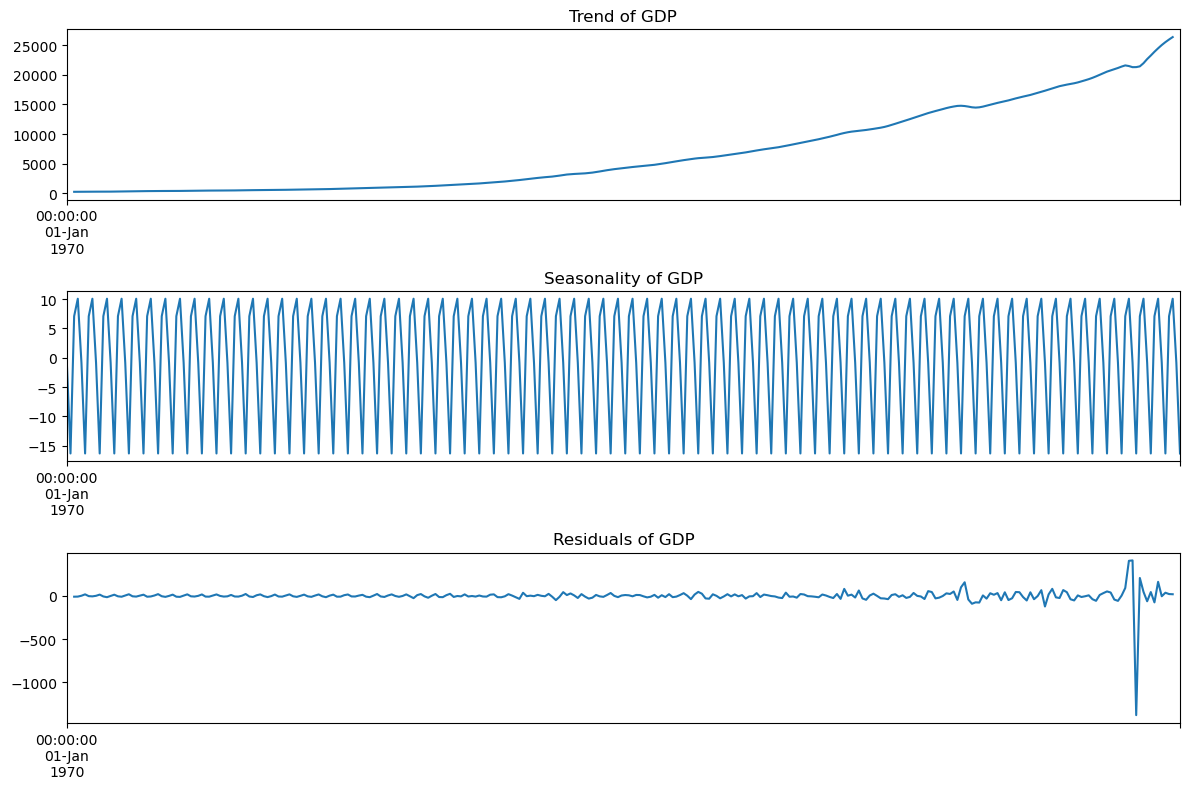

In [10]:

economic_data.index = pd.to_datetime(economic_data.index)
decomposition = sm.tsa.seasonal_decompose(economic_data['GDP'].dropna(), model='additive', period=4)
# Plotting the decomposed time series
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 8))
decomposition.trend.plot(ax=ax1)
ax1.set_title('Trend of GDP')
decomposition.seasonal.plot(ax=ax2)
ax2.set_title('Seasonality of GDP')
decomposition.resid.plot(ax=ax3)
ax3.set_title('Residuals of GDP')
plt.tight_layout()
plt.show()

## LSTM Model

In [15]:
n_future = 1
n_past = 16 
economic_war_data = load_data('../data/war_final.csv')
economic_data_scaled, _ = preprocess_data(economic_war_data)
(X_train, y_train), (X_test, y_test) = train_data_split(economic_data_scaled, n_future, n_past)

train_size =  261
test_size =  29
train_size =  (261, 16, 12)
test_size =  (29, 16, 12)


#### Hyperparameter Tuning On Number_nodes and Batch_size

In [17]:
param_grid = {
    'num_nodes': [8, 16, 32, 64],
    'batch_size': [1, 4, 8],
    'activation':['relu'],
    'drop_out': [0.1],
    'init_mode': ['glorot_uniform'],
    'optimizer':['Adam'],
    'learning_rate': [0.01]
}

list_of_trained_model=grid_search(param_grid,X_train,y_train,model_type='LSTM')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8)                 672       
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 681
Trainable params: 681
Non-trainable params: 0
_________________________________________________________________
X_train (261, 16, 12)
y_train (261, 1)


2023-12-17 18:53:44.839422: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 8)                 672       
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 681
Trainable params: 681
Non-trainable params: 0
_________________________________________________________________
X_train (261, 16, 12)
y_train (261, 1)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 8)                 672       
                                                             

In [18]:
print(list_of_trained_model[0].params)

{'num_nodes': 8, 'batch_size': 1, 'activation': 'relu', 'drop_out': 0.1, 'init_mode': 'glorot_uniform', 'optimizer': 'Adam', 'learning_rate': 0.01}


In [19]:
for i in range(len(list_of_trained_model)):
    print(list_of_trained_model[i].params)


{'num_nodes': 8, 'batch_size': 1, 'activation': 'relu', 'drop_out': 0.1, 'init_mode': 'glorot_uniform', 'optimizer': 'Adam', 'learning_rate': 0.01}
{'num_nodes': 8, 'batch_size': 4, 'activation': 'relu', 'drop_out': 0.1, 'init_mode': 'glorot_uniform', 'optimizer': 'Adam', 'learning_rate': 0.01}
{'num_nodes': 8, 'batch_size': 8, 'activation': 'relu', 'drop_out': 0.1, 'init_mode': 'glorot_uniform', 'optimizer': 'Adam', 'learning_rate': 0.01}
{'num_nodes': 16, 'batch_size': 1, 'activation': 'relu', 'drop_out': 0.1, 'init_mode': 'glorot_uniform', 'optimizer': 'Adam', 'learning_rate': 0.01}
{'num_nodes': 16, 'batch_size': 4, 'activation': 'relu', 'drop_out': 0.1, 'init_mode': 'glorot_uniform', 'optimizer': 'Adam', 'learning_rate': 0.01}
{'num_nodes': 16, 'batch_size': 8, 'activation': 'relu', 'drop_out': 0.1, 'init_mode': 'glorot_uniform', 'optimizer': 'Adam', 'learning_rate': 0.01}
{'num_nodes': 32, 'batch_size': 1, 'activation': 'relu', 'drop_out': 0.1, 'init_mode': 'glorot_uniform', 'opt

In [20]:
for i in range(len(list_of_trained_model)):
    print('model=', list_of_trained_model[i].model,'loss=', list_of_trained_model[i].loss)


model= <keras.engine.sequential.Sequential object at 0x1652a7070> loss= 0.045481130480766296
model= <keras.engine.sequential.Sequential object at 0x1655f49d0> loss= 0.02451900765299797
model= <keras.engine.sequential.Sequential object at 0x1660fdcd0> loss= 0.030340304598212242
model= <keras.engine.sequential.Sequential object at 0x16748f4f0> loss= 0.047340329736471176
model= <keras.engine.sequential.Sequential object at 0x169835760> loss= 0.025422172620892525
model= <keras.engine.sequential.Sequential object at 0x173bfff70> loss= 0.019777171313762665
model= <keras.engine.sequential.Sequential object at 0x173c5f160> loss= 0.02893197536468506
model= <keras.engine.sequential.Sequential object at 0x173ce9940> loss= 0.023890268057584763
model= <keras.engine.sequential.Sequential object at 0x173d63250> loss= 0.015589447692036629
model= <keras.engine.sequential.Sequential object at 0x173dbad00> loss= 0.05648175626993179
model= <keras.engine.sequential.Sequential object at 0x173e25af0> loss= 0

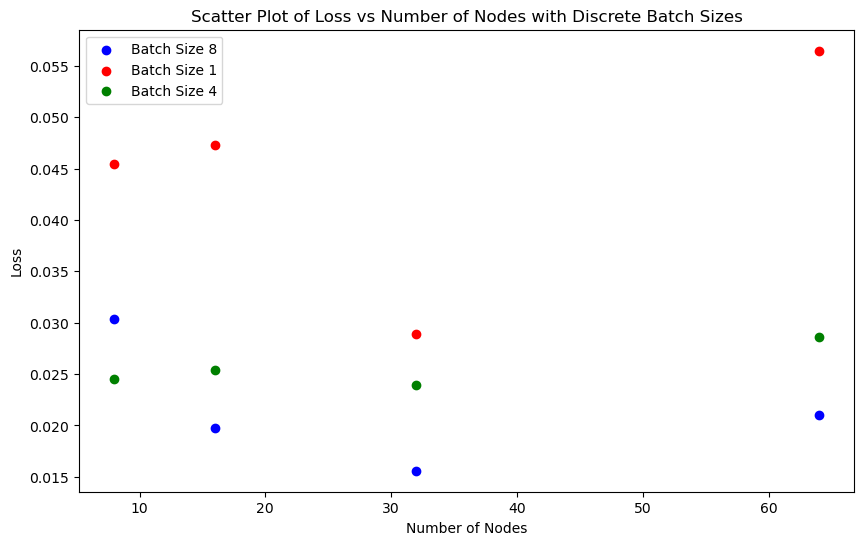

In [21]:
batch_size = []
num_nodes = []
loss = []

for i in range(len(list_of_trained_model)):
    batch_size.append(list_of_trained_model[i].params['batch_size'])
    num_nodes.append(list_of_trained_model[i].params['num_nodes'])
    loss.append(list_of_trained_model[i].loss)

color_map = {1: 'red', 4: 'green', 8: 'blue'}

plt.figure(figsize=(10, 6))

for batch in set(batch_size):
    idx = [i for i, b in enumerate(batch_size) if b == batch]
    plt.scatter([num_nodes[i] for i in idx], [loss[i] for i in idx], color=color_map[batch], label=f'Batch Size {batch}')

plt.xlabel('Number of Nodes')
plt.ylabel('Loss')
plt.title('Scatter Plot of Loss vs Number of Nodes with Discrete Batch Sizes')
plt.legend()
plt.show()


### Hyperparameter Tuning On Learning Rate and Optimizer

In [22]:
param_grid = {
    'num_nodes': [32],
    'batch_size': [4],
    'activation':['relu'],
    'drop_out': [0.1],
    'init_mode': ['glorot_uniform'],
    'optimizer': ['SGD', 'Adam'],
    'learning_rate': [0.0001, 0.001, 0.01]
}

list_of_trained_model=grid_search(param_grid,X_train,y_train,model_type='LSTM')

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 32)                5760      
                                                                 
 dropout_12 (Dropout)        (None, 32)                0         
                                                                 
 dense_12 (Dense)            (None, 1)                 33        
                                                                 
Total params: 5,793
Trainable params: 5,793
Non-trainable params: 0
_________________________________________________________________
X_train (261, 16, 12)
y_train (261, 1)
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 32)                5760      
                                                       

In [23]:
for i in range(len(list_of_trained_model)):
    print('loss=', list_of_trained_model[i].loss,'params=',list_of_trained_model[i].params)

loss= 0.25483185052871704 params= {'num_nodes': 32, 'batch_size': 4, 'activation': 'relu', 'drop_out': 0.1, 'init_mode': 'glorot_uniform', 'optimizer': 'SGD', 'learning_rate': 0.0001}
loss= 0.03196881711483002 params= {'num_nodes': 32, 'batch_size': 4, 'activation': 'relu', 'drop_out': 0.1, 'init_mode': 'glorot_uniform', 'optimizer': 'SGD', 'learning_rate': 0.001}
loss= 0.028728505596518517 params= {'num_nodes': 32, 'batch_size': 4, 'activation': 'relu', 'drop_out': 0.1, 'init_mode': 'glorot_uniform', 'optimizer': 'SGD', 'learning_rate': 0.01}
loss= 0.024272892624139786 params= {'num_nodes': 32, 'batch_size': 4, 'activation': 'relu', 'drop_out': 0.1, 'init_mode': 'glorot_uniform', 'optimizer': 'Adam', 'learning_rate': 0.0001}
loss= 0.020713036879897118 params= {'num_nodes': 32, 'batch_size': 4, 'activation': 'relu', 'drop_out': 0.1, 'init_mode': 'glorot_uniform', 'optimizer': 'Adam', 'learning_rate': 0.001}
loss= 0.022442664951086044 params= {'num_nodes': 32, 'batch_size': 4, 'activati

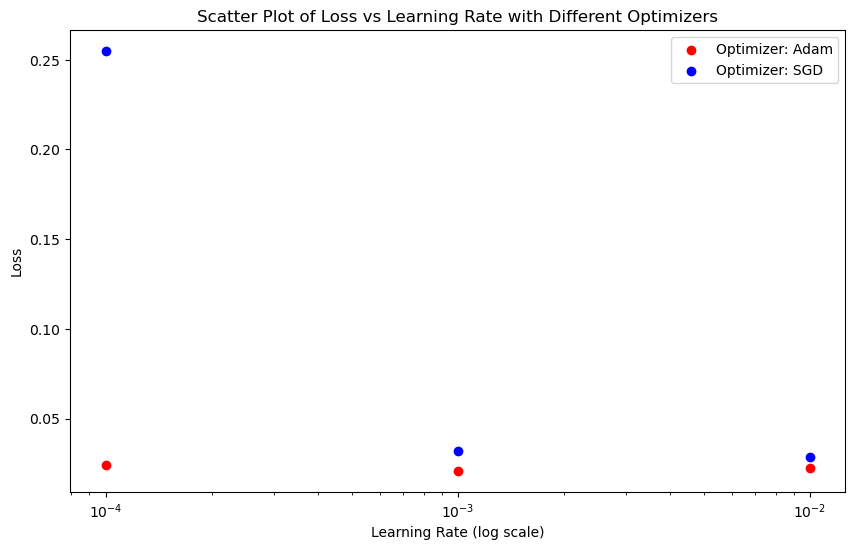

In [24]:
loss = []
learning_rates = []
optimizers = []

for model in list_of_trained_model:
    loss.append(model.loss)
    learning_rates.append(model.params['learning_rate'])
    optimizers.append(model.params['optimizer'])

loss = np.array(loss)
learning_rates = np.array(learning_rates)
optimizers = np.array(optimizers)

color_map = {'SGD': 'blue', 'Adam': 'red'}

plt.figure(figsize=(10, 6))
for optimizer in np.unique(optimizers):
    idx = optimizers == optimizer
    plt.scatter(learning_rates[idx],loss[idx],color=color_map[optimizer], label=f'Optimizer: {optimizer}')

plt.xlabel('Learning Rate (log scale)')
plt.ylabel('Loss')
plt.xscale('log')
plt.title('Scatter Plot of Loss vs Learning Rate with Different Optimizers')
plt.legend()
plt.show()



### Hyperparameter Tuning On Dropout, activation and weight initialization

In [25]:
param_grid = {
    'num_nodes': [32],
    'batch_size': [4],
    'activation':['relu', 'tanh', 'sigmoid'],
    'drop_out': [0.1, 0.2, 0.6, 0.8],
    'init_mode': ['glorot_uniform', 'uniform', 'normal', 'glorot_normal'],
    'optimizer': ['Adam'],
    'learning_rate': [0.001]
}

list_of_trained_model=grid_search(param_grid,X_train,y_train,model_type='LSTM')

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 32)                5760      
                                                                 
 dropout_18 (Dropout)        (None, 32)                0         
                                                                 
 dense_18 (Dense)            (None, 1)                 33        
                                                                 
Total params: 5,793
Trainable params: 5,793
Non-trainable params: 0
_________________________________________________________________
X_train (261, 16, 12)
y_train (261, 1)
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, 32)                5760      
                                                       

In [26]:
for i in range(len(list_of_trained_model)):
    print('loss=', list_of_trained_model[i].loss,'params=',list_of_trained_model[i].params)

loss= 0.016823410987854004 params= {'num_nodes': 32, 'batch_size': 4, 'activation': 'relu', 'drop_out': 0.1, 'init_mode': 'glorot_uniform', 'optimizer': 'Adam', 'learning_rate': 0.001}
loss= 0.014609686098992825 params= {'num_nodes': 32, 'batch_size': 4, 'activation': 'relu', 'drop_out': 0.1, 'init_mode': 'uniform', 'optimizer': 'Adam', 'learning_rate': 0.001}
loss= 0.013374055735766888 params= {'num_nodes': 32, 'batch_size': 4, 'activation': 'relu', 'drop_out': 0.1, 'init_mode': 'normal', 'optimizer': 'Adam', 'learning_rate': 0.001}
loss= 0.014320354908704758 params= {'num_nodes': 32, 'batch_size': 4, 'activation': 'relu', 'drop_out': 0.1, 'init_mode': 'glorot_normal', 'optimizer': 'Adam', 'learning_rate': 0.001}
loss= 0.018037205561995506 params= {'num_nodes': 32, 'batch_size': 4, 'activation': 'relu', 'drop_out': 0.2, 'init_mode': 'glorot_uniform', 'optimizer': 'Adam', 'learning_rate': 0.001}
loss= 0.01570776104927063 params= {'num_nodes': 32, 'batch_size': 4, 'activation': 'relu', 

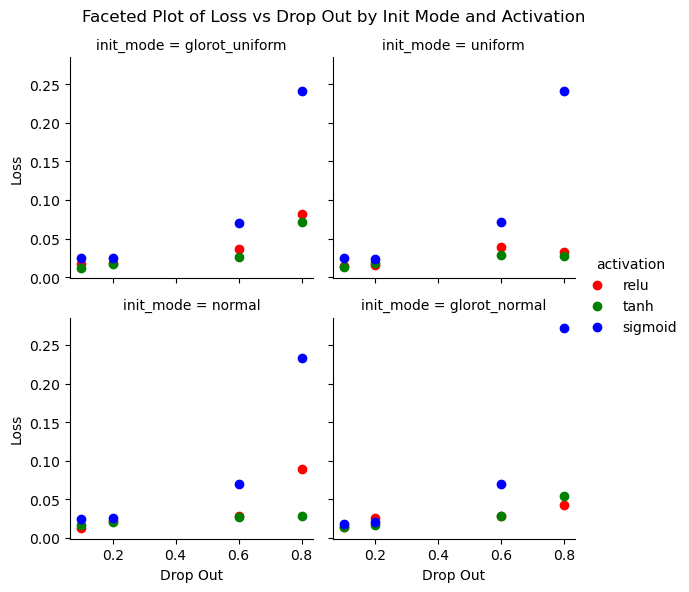

In [27]:
data = []
for model in list_of_trained_model:
    data.append({
        'loss': model.loss,
        'drop_out': model.params['drop_out'],
        'init_mode': model.params['init_mode'],
        'activation': model.params['activation']
    })

df = pd.DataFrame(data)
color_map = {'relu': 'red', 'tanh': 'green', 'sigmoid': 'blue'}
g = sns.FacetGrid(df, col="init_mode", hue='activation', palette=color_map, col_wrap=2)
g.map(plt.scatter, 'drop_out', 'loss')
g.add_legend()
g.set_axis_labels("Drop Out", "Loss")
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Faceted Plot of Loss vs Drop Out by Init Mode and Activation')

plt.show()


### HyperParameter Tunning On Epoch

In [29]:
param_grid = {
    'num_nodes': 32,
    'batch_size': 4,
    'activation':'tanh',
    'drop_out': 0.1,
    'init_mode': 'glorot_uniform',
    'optimizer': 'Adam',
    'learning_rate': 0.001
}
window=16
features=12
n_future = 1
n_past = window  
economic_war_data = load_data('../data/war_final.csv')
economic_data_scaled, _ = preprocess_data(economic_war_data)
(X_train, y_train), (X_test, y_test) = train_data_split(economic_data_scaled, n_future, n_past)
num_nodes=param_grid['num_nodes']
learning_rate=param_grid['learning_rate']
drop_out=param_grid['drop_out']
init_mode=param_grid['init_mode']
activation=param_grid['activation']
optimizer=param_grid['optimizer']
n_batch=param_grid['batch_size']
final_chosen_model=define_model_lstm(num_nodes, learning_rate, drop_out, activation, init_mode, optimizer,window,features)
final_trained_model = train_model(final_chosen_model, X_train, y_train,n_batch,epochs=100)

train_size =  261
test_size =  29
train_size =  (261, 16, 12)
test_size =  (29, 16, 12)
Model: "sequential_67"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_67 (LSTM)              (None, 32)                5760      
                                                                 
 dropout_67 (Dropout)        (None, 32)                0         
                                                                 
 dense_67 (Dense)            (None, 1)                 33        
                                                                 
Total params: 5,793
Trainable params: 5,793
Non-trainable params: 0
_________________________________________________________________
X_train (261, 16, 12)
y_train (261, 1)


In [30]:
final_trained_model.history['loss']

[0.19703316688537598,
 0.015253745019435883,
 0.015027599409222603,
 0.013468874618411064,
 0.012925407849252224,
 0.010431705974042416,
 0.008651245385408401,
 0.009225821122527122,
 0.008268258534371853,
 0.006879779044538736,
 0.007074348162859678,
 0.008459361270070076,
 0.005959491711109877,
 0.00654549291357398,
 0.007055112160742283,
 0.008592700585722923,
 0.0062425946816802025,
 0.004855641629546881,
 0.006724303588271141,
 0.005795806646347046,
 0.0046679372899234295,
 0.005495406221598387,
 0.004020169377326965,
 0.004817246459424496,
 0.005775144789367914,
 0.005152038298547268,
 0.004711145535111427,
 0.005622496362775564,
 0.0048830690793693066,
 0.004410645924508572,
 0.003974246326833963,
 0.003321579424664378,
 0.004366718698292971,
 0.004674909636378288,
 0.004000969231128693,
 0.0041266875341534615,
 0.004787624813616276,
 0.003298451192677021,
 0.004281609319150448,
 0.0036699294578284025,
 0.003617829643189907,
 0.0035664327442646027,
 0.003936889115720987,
 0.0035

In [31]:
lstm_train_df = pd.DataFrame({
    'LSTM_TRAIN_MSE': final_trained_model.history['loss'],
    'LSTM_TRAIN_RMSE': final_trained_model.history['root_mean_squared_error']
})

lstm_val_df = pd.DataFrame({
    'LSTM_VAL_MSE': final_trained_model.history['val_loss'],
    'LSTM_VAL_RMSE': final_trained_model.history['val_root_mean_squared_error']
})
concatenated_df = pd.concat([lstm_train_df, lstm_val_df], axis=1)
concatenated_df['epoch'] = range(0, len(concatenated_df))
concatenated_df

,LSTM_TRAIN_MSE,LSTM_TRAIN_RMSE,LSTM_VAL_MSE,LSTM_VAL_RMSE,epoch
0,0.197033,0.443884,0.017379,0.131828,0
1,0.015254,0.123506,0.012868,0.113439,1
2,0.015028,0.122587,0.017882,0.133723,2
3,0.013469,0.116055,0.014488,0.120367,3
4,0.012925,0.113690,0.002481,0.049808,4
...,...,...,...,...,...
95,0.002969,0.054487,0.002237,0.047299,95
96,0.003572,0.059767,0.019139,0.138343,96
97,0.003223,0.056772,0.001346,0.036694,97
98,0.002572,0.050710,0.003538,0.059484,98


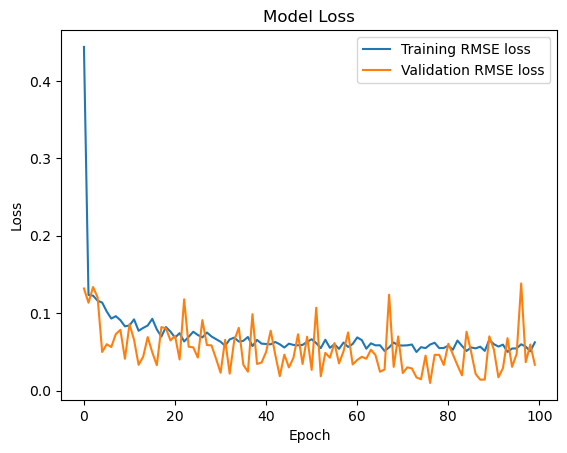

In [32]:
plt.plot(concatenated_df['epoch'], concatenated_df['LSTM_TRAIN_RMSE'], label='Training RMSE loss')
plt.plot(concatenated_df['epoch'], concatenated_df['LSTM_VAL_RMSE'], label='Validation RMSE loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch') 
plt.legend(loc='upper right')
plt.show()


### Hyperparameter Tuning On Input Sequence Window Size

In [35]:
param_grid = {
    'num_nodes': 24,
    'batch_size': 4,
    'activation':'tanh',
    'drop_out': 0.1,
    'init_mode': 'glorot_uniform',
    'optimizer': 'Adam',
    'learning_rate': 0.001
}
windows=[8,12,16,20,24,28]
features=12
n_future = 1
rmse_scores = {}
economic_war_data = load_data('../data/war_final.csv')
economic_data_scaled, _ = preprocess_data(economic_war_data)
for window in windows:
    n_past=window
    (X_train, y_train), (X_test, y_test) = train_data_split(economic_data_scaled, n_future, n_past)
    num_nodes=param_grid['num_nodes']
    learning_rate=param_grid['learning_rate']
    drop_out=param_grid['drop_out']
    init_mode=param_grid['init_mode']
    activation=param_grid['activation']
    optimizer=param_grid['optimizer']
    n_batch=param_grid['batch_size']
    model_gru=define_model_gru(num_nodes, learning_rate, drop_out, activation, init_mode, optimizer, features = features,window=window)
    trained_model_gru = train_model(model_gru, X_train, y_train, n_batch, epochs=28)
    rmse_scores[window] = min(trained_model_gru.history['val_root_mean_squared_error'])
input_size_df=pd.DataFrame(list(rmse_scores.items()), columns=['Window_Size', 'RMSE']) 

train_size =  268
test_size =  30
train_size =  (268, 8, 12)
test_size =  (30, 8, 12)
Model: "sequential_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 24)                2736      
                                                                 
 dropout_69 (Dropout)        (None, 24)                0         
                                                                 
 dense_69 (Dense)            (None, 1)                 25        
                                                                 
Total params: 2,761
Trainable params: 2,761
Non-trainable params: 0
_________________________________________________________________
X_train (268, 8, 12)
y_train (268, 1)
train_size =  264
test_size =  30
train_size =  (264, 12, 12)
test_size =  (30, 12, 12)
Model: "sequential_70"
_________________________________________________________________
 Layer (type) 

In [36]:
input_size_df.sort_values(by='RMSE')

,Window_Size,RMSE
3,20,0.018199
4,24,0.019726
0,8,0.022037
5,28,0.022372
2,16,0.023722
1,12,0.026215


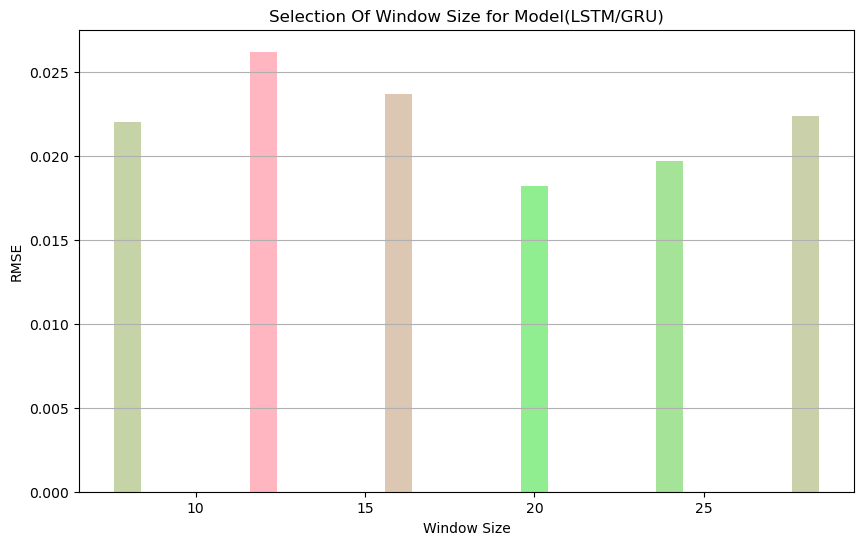

In [37]:
df_sorted = input_size_df.sort_values(by="RMSE")
def interpolate_color(value, min_val, max_val):
    normalized = (value - min_val) / (max_val - min_val)
    light_green = np.array([144, 238, 144]) / 255.0
    light_red = np.array([255, 182, 193]) / 255.0
    color = light_green * (1 - normalized) + light_red * normalized

    return color

min_rmse = df_sorted['RMSE'].min()
max_rmse = df_sorted['RMSE'].max()
colors = [interpolate_color(value, min_rmse, max_rmse) for value in df_sorted['RMSE']]
plt.figure(figsize=(10, 6))
plt.bar(df_sorted["Window_Size"], df_sorted["RMSE"], color=colors)
plt.title("Selection Of Window Size for Model(LSTM/GRU)")
plt.xlabel("Window Size")
plt.ylabel("RMSE")
plt.grid(axis='y')
plt.show()

## 1D CNN

### Hyperparameter Tuning on Number Of nodes vs batch_size

In [43]:
param_grid = {
    'num_nodes': [8, 16, 24, 32],
    'batch_size': [1, 4],
    'activation':['relu'],
    'drop_out': [0.1],
    'init_mode': ['glorot_uniform'],
    'optimizer':['Adam'],
    'learning_rate': [0.01],
    'kernel_size':[3]
}
n_future = 1
n_past = 16
(X_train, y_train), (X_test, y_test) = train_data_split(economic_data_scaled, n_future, n_past)
list_of_trained_model_cnn=grid_search(param_grid, X_train, y_train, model_type='CNN')

train_size =  261
test_size =  29
train_size =  (261, 16, 12)
test_size =  (29, 16, 12)
Model: "sequential_79"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 14, 8)             296       
                                                                 
 dropout_79 (Dropout)        (None, 14, 8)             0         
                                                                 
 flatten_4 (Flatten)         (None, 112)               0         
                                                                 
 dense_79 (Dense)            (None, 1)                 113       
                                                                 
Total params: 409
Trainable params: 409
Non-trainable params: 0
_________________________________________________________________
X_train (261, 16, 12)
y_train (261, 1)
Model: "sequential_80"
_____________________________________

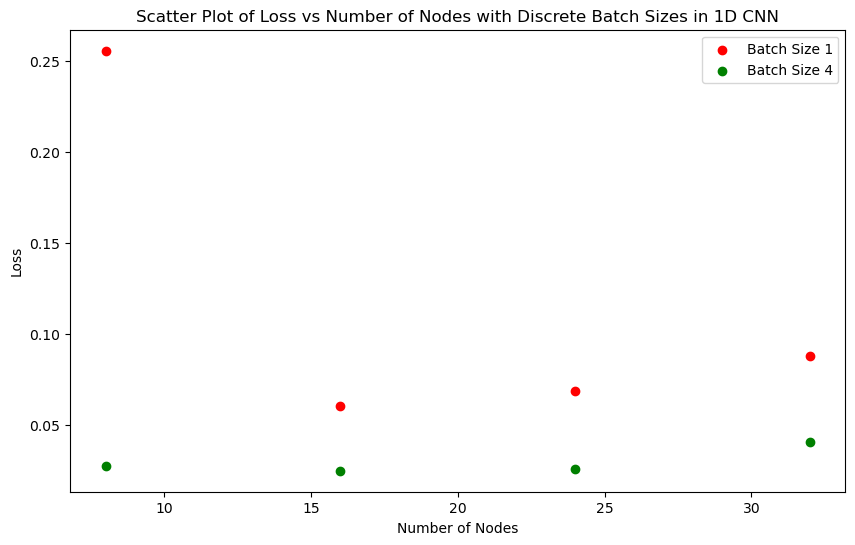

In [44]:
import matplotlib.pyplot as plt

batch_size = []
num_nodes = []
loss = []

for i in range(len(list_of_trained_model_cnn)):
    batch_size.append(list_of_trained_model_cnn[i].params['batch_size'])
    num_nodes.append(list_of_trained_model_cnn[i].params['num_nodes'])
    loss.append(list_of_trained_model_cnn[i].loss)

color_map = {1: 'red', 4: 'green'}
plt.figure(figsize=(10, 6))

for batch in set(batch_size):
    idx = [i for i, b in enumerate(batch_size) if b == batch]
    plt.scatter([num_nodes[i] for i in idx], [loss[i] for i in idx], color=color_map[batch], label=f'Batch Size {batch}')

plt.xlabel('Number of Nodes')
plt.ylabel('Loss')
plt.title('Scatter Plot of Loss vs Number of Nodes with Discrete Batch Sizes in 1D CNN')
plt.legend()
plt.show()

### Hyperparameter Tuning on learning_rate vs optimizer vs activation

In [45]:
param_grid = {
    'num_nodes': [24],
    'batch_size': [4],
    'activation':['relu','tanh'],
    'drop_out': [0.1],
    'init_mode': ['glorot_uniform',],
    'optimizer':['Adam','SGD'],
    'learning_rate': [0.0001, 0.001, 0.01],
    'kernel_size':[3]
}

list_of_trained_model_cnn=grid_search(param_grid,X_train,y_train,model_type='CNN')

Model: "sequential_87"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 14, 24)            888       
                                                                 
 dropout_87 (Dropout)        (None, 14, 24)            0         
                                                                 
 flatten_12 (Flatten)        (None, 336)               0         
                                                                 
 dense_87 (Dense)            (None, 1)                 337       
                                                                 
Total params: 1,225
Trainable params: 1,225
Non-trainable params: 0
_________________________________________________________________
X_train (261, 16, 12)
y_train (261, 1)
Model: "sequential_88"
_________________________________________________________________
 Layer (type)                Output Shape              

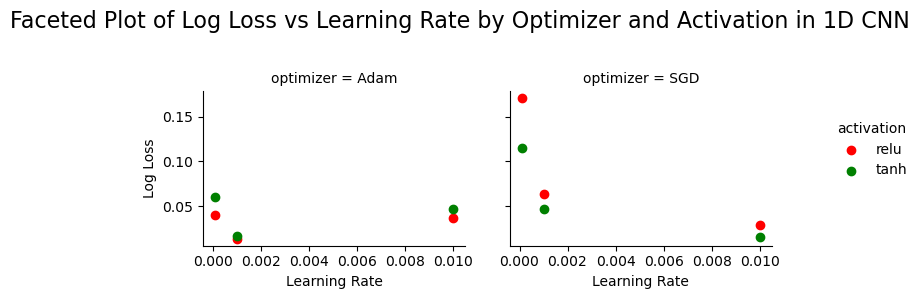

In [46]:
data = []
for model in list_of_trained_model_cnn:
    log_loss = model.loss 
    learning_rate = model.params['learning_rate'] 
    data.append({
        'loss': log_loss,
        'learning_rate': learning_rate, 
        'optimizer': model.params['optimizer'],
        'activation': model.params['activation']
    })

df = pd.DataFrame(data)

color_map = {'relu': 'red', 'tanh': 'green'}

g = sns.FacetGrid(df, col="optimizer", hue='activation', palette=color_map, col_wrap=2)
g.map(plt.scatter, 'learning_rate', 'loss') 

g.add_legend()
g.set_axis_labels("Learning Rate", "Log Loss")
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Faceted Plot of Log Loss vs Learning Rate by Optimizer and Activation in 1D CNN', fontsize=16)
g.fig.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()



### Hyperparameter Tuning on dropout vs init_mode vs kernel_size

In [47]:
param_grid = {
    'num_nodes': [24],
    'batch_size': [4],
    'activation':['tanh'],
    'drop_out': [0.1,.2],
    'init_mode': ['glorot_uniform','glorot_normal'],
    'optimizer':['Adam'],
    'learning_rate': [0.001],
    'kernel_size':[2,3,5]
}

list_of_trained_model_cnn=grid_search(param_grid,X_train,y_train,model_type='CNN')

Model: "sequential_99"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_24 (Conv1D)          (None, 15, 24)            600       
                                                                 
 dropout_99 (Dropout)        (None, 15, 24)            0         
                                                                 
 flatten_24 (Flatten)        (None, 360)               0         
                                                                 
 dense_99 (Dense)            (None, 1)                 361       
                                                                 
Total params: 961
Trainable params: 961
Non-trainable params: 0
_________________________________________________________________
X_train (261, 16, 12)
y_train (261, 1)
Model: "sequential_100"
_________________________________________________________________
 Layer (type)                Output Shape              Par

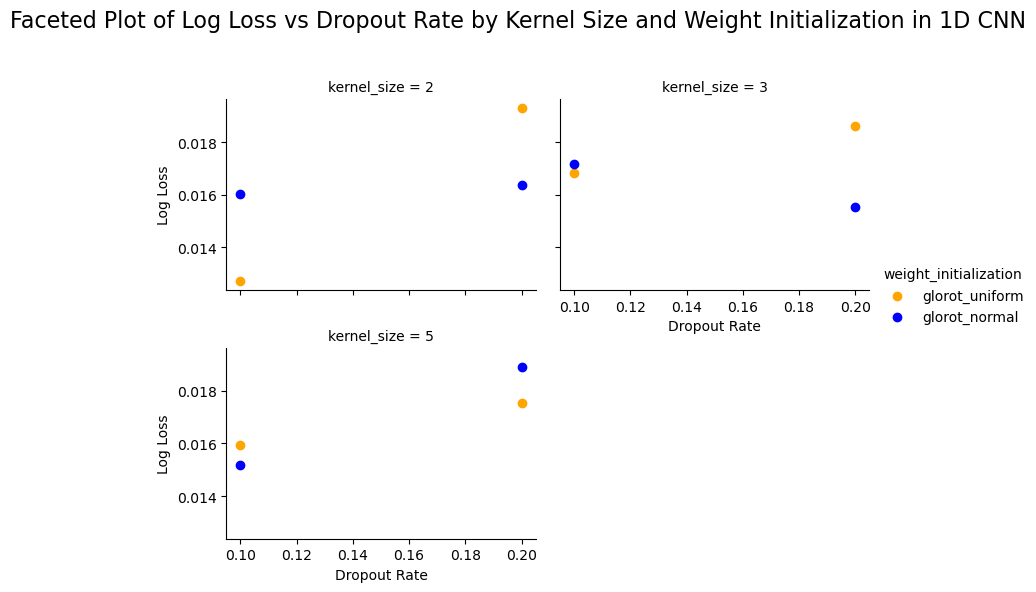

In [48]:
data = []
for model in list_of_trained_model_cnn:
    log_loss = model.loss
    data.append({
        'loss': log_loss,
        'kernel_size': model.params['kernel_size'],
        'dropout': model.params['drop_out'],
        'weight_initialization': model.params['init_mode']
    })

df = pd.DataFrame(data)
color_map = {'glorot_uniform': 'orange', 'glorot_normal': 'blue'}

g = sns.FacetGrid(df, col="kernel_size", hue='weight_initialization', palette=color_map, col_wrap=2)
g.map(plt.scatter, 'dropout', 'loss')  
g.add_legend()
g.set_axis_labels("Dropout Rate", "Log Loss")
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Faceted Plot of Log Loss vs Dropout Rate by Kernel Size and Weight Initialization in 1D CNN', fontsize=16)
g.fig.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()


### Model training with new hyperparameter

In [131]:
param_grid = {
    'num_nodes': 24,
    'batch_size': 4,
    'activation':'tanh',
    'drop_out': 0.1,
    'init_mode': 'glorot_uniform',
    'optimizer': 'Adam',
    'learning_rate': 0.001,
    'kernel_size':2
}
windows=[8,12,16,20,24,28]
features=12
n_future = 1
rmse_scores = {}
economic_war_data = load_data('../data/war_final.csv')
economic_data_scaled , _ = preprocess_data(economic_war_data)
for window in windows:
    n_past = window
    (X_train, y_train), (X_test, y_test) = train_data_split(economic_data_scaled, n_future, n_past)
    num_nodes=param_grid['num_nodes']
    learning_rate=param_grid['learning_rate']
    drop_out=param_grid['drop_out']
    init_mode=param_grid['init_mode']
    activation=param_grid['activation']
    optimizer=param_grid['optimizer']
    n_batch=param_grid['batch_size']
    kernel_size=param_grid['kernel_size']
    model_cnn=define_model_cnn(num_nodes, learning_rate, drop_out, activation, init_mode, optimizer, kernel_size=kernel_size, features= features, window= window)
    trained_model_cnn = train_model(model_cnn, X_train, y_train, n_batch, epochs=22)
    rmse_scores[window] = min(trained_model_cnn.history['val_root_mean_squared_error'])
input_size_cnn_df=pd.DataFrame(list(rmse_scores.items()), columns=['Window_Size_cnn', 'RMSE']) 

train_size =  268
test_size =  30
train_size =  (268, 8, 12)
test_size =  (30, 8, 12)
Model: "sequential_227"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_140 (Conv1D)         (None, 7, 24)             600       
                                                                 
 dropout_227 (Dropout)       (None, 7, 24)             0         
                                                                 
 flatten_140 (Flatten)       (None, 168)               0         
                                                                 
 dense_227 (Dense)           (None, 1)                 169       
                                                                 
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________
X_train (268, 8, 12)
y_train (268, 1)
train_size =  264
test_size =  30
train_size =  (264, 12, 12)


In [132]:
input_size_cnn_df.sort_values(by='RMSE')

,Window_Size_cnn,RMSE
3,20,0.041644
0,8,0.043254
2,16,0.046902
4,24,0.048064
1,12,0.050451
5,28,0.051946


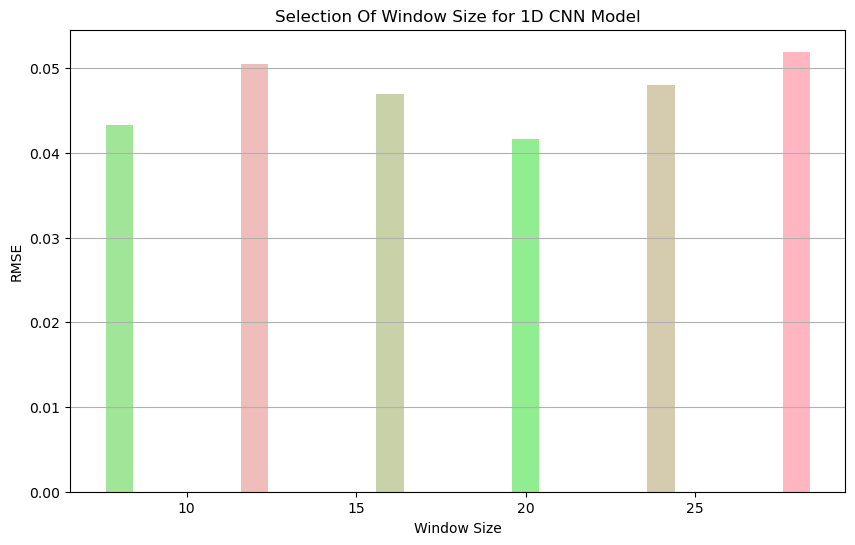

In [133]:
df_sorted = input_size_cnn_df.sort_values(by="RMSE")
def interpolate_color(value, min_val, max_val):
    normalized = (value - min_val) / (max_val - min_val)
    light_green = np.array([144, 238, 144]) / 255.0
    light_red = np.array([255, 182, 193]) / 255.0
    color = light_green * (1 - normalized) + light_red * normalized

    return color

min_rmse = df_sorted['RMSE'].min()
max_rmse = df_sorted['RMSE'].max()
colors = [interpolate_color(value, min_rmse, max_rmse) for value in df_sorted['RMSE']]
plt.figure(figsize=(10, 6))
plt.bar(df_sorted["Window_Size_cnn"], df_sorted["RMSE"], color=colors)
plt.title("Selection Of Window Size for 1D CNN Model")
plt.xlabel("Window Size")
plt.ylabel("RMSE")
plt.grid(axis='y')
plt.show()



### CNN model training with all hyperparameter in place

In [162]:
param_grid = {
    'num_nodes': 24,
    'batch_size': 4,
    'activation':'tanh',
    'drop_out': 0.1,
    'init_mode': 'glorot_uniform',
    'optimizer': 'Adam',
    'learning_rate': 0.001,
    'kernel_size':2
}
window = 20
features = 12
n_future = 1
(X_train, y_train), (X_test, y_test) = train_data_split(economic_data_scaled, n_future, n_past = window)
model_cnn=define_model_cnn(num_nodes, learning_rate, drop_out, activation, init_mode, optimizer, kernel_size=kernel_size, features = features,window=window)
trained_model_cnn = train_model(model_cnn, X_train, y_train, n_batch, epochs=100)

cnn_train_df = pd.DataFrame({
    'CNN_TRAIN_MSE': trained_model_cnn.history['loss'],
    'CNN_TRAIN_RMSE': trained_model_cnn.history['root_mean_squared_error']
})

cnn_val_df = pd.DataFrame({
    'CNN_VAL_MSE': trained_model_cnn.history['val_loss'],
    'CNN_VAL_RMSE': trained_model_cnn.history['val_root_mean_squared_error']
})
concatenated_df_cnn = pd.concat([cnn_train_df, cnn_val_df], axis=1)
concatenated_df_cnn['epoch'] = range(0, len(concatenated_df_cnn))
concatenated_df_cnn

train_size =  257
test_size =  29
train_size =  (257, 20, 12)
test_size =  (29, 20, 12)
Model: "sequential_240"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_149 (Conv1D)         (None, 19, 24)            600       
                                                                 
 dropout_240 (Dropout)       (None, 19, 24)            0         
                                                                 
 flatten_149 (Flatten)       (None, 456)               0         
                                                                 
 dense_240 (Dense)           (None, 1)                 457       
                                                                 
Total params: 1,057
Trainable params: 1,057
Non-trainable params: 0
_________________________________________________________________
X_train (257, 20, 12)
y_train (257, 1)


,CNN_TRAIN_MSE,CNN_TRAIN_RMSE,CNN_VAL_MSE,CNN_VAL_RMSE,epoch
0,0.089757,0.299595,0.020071,0.141673,0
1,0.066026,0.256955,0.008971,0.094715,1
2,0.040667,0.201660,0.019352,0.139112,2
3,0.034320,0.185256,0.010098,0.100490,3
4,0.030562,0.174820,0.027072,0.164537,4
...,...,...,...,...,...
95,0.001182,0.034381,0.001400,0.037415,95
96,0.001354,0.036800,0.003620,0.060164,96
97,0.001250,0.035353,0.001642,0.040516,97
98,0.001740,0.041711,0.001165,0.034131,98


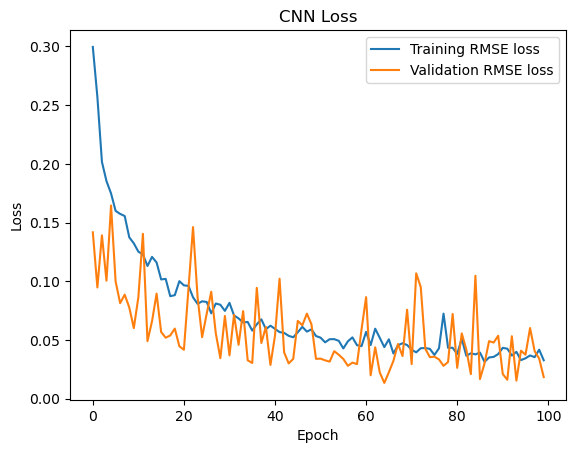

In [145]:
plt.plot(concatenated_df_cnn['epoch'], concatenated_df_cnn['CNN_TRAIN_RMSE'], label='Training RMSE loss')
plt.plot(concatenated_df_cnn['epoch'], concatenated_df_cnn['CNN_VAL_RMSE'], label='Validation RMSE loss')
plt.title('CNN Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch') 
plt.legend(loc='upper right')
plt.show()

### GRU

In [160]:
param_grid = {
    'num_nodes': 24,
    'batch_size': 4,
    'activation':'tanh',
    'drop_out': 0.1,
    'init_mode': 'glorot_uniform',
    'optimizer': 'Adam',
    'learning_rate': 0.001
}
n_future = 1
window = 20
economic_war_data = load_data('../data/war_final.csv')
economic_data_scaled, _ = preprocess_data(economic_war_data)
(X_train, y_train), (X_test, y_test) = train_data_split(economic_data_scaled, n_future, n_past = window)
num_nodes=param_grid['num_nodes']
learning_rate=param_grid['learning_rate']
drop_out=param_grid['drop_out']
init_mode=param_grid['init_mode']
activation=param_grid['activation']
optimizer=param_grid['optimizer']
n_batch=param_grid['batch_size']
model_gru = define_model_gru(num_nodes, learning_rate, drop_out, activation, init_mode, optimizer, window, features)
trained_model_gru = train_model(model_gru, X_train, y_train, n_batch, epochs=100)

train_size =  257
test_size =  29
train_size =  (257, 20, 12)
test_size =  (29, 20, 12)
Model: "sequential_238"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_22 (GRU)                (None, 24)                2736      
                                                                 
 dropout_238 (Dropout)       (None, 24)                0         
                                                                 
 dense_238 (Dense)           (None, 1)                 25        
                                                                 
Total params: 2,761
Trainable params: 2,761
Non-trainable params: 0
_________________________________________________________________
X_train (257, 20, 12)
y_train (257, 1)


In [147]:
gru_train_df = pd.DataFrame({
    'GRU_TRAIN_MSE': trained_model_gru.history['loss'],
    'GRU_TRAIN_RMSE': trained_model_gru.history['root_mean_squared_error']
})
gru_val_df = pd.DataFrame({
    'GRU_VAL_MSE': trained_model_gru.history['val_loss'],
    'GRU_VAL_RMSE': trained_model_gru.history['val_root_mean_squared_error']
})
concatenated_df_gru = pd.concat([gru_train_df, gru_val_df], axis=1)
concatenated_df_gru['epoch'] = range(0, len(concatenated_df_gru))
concatenated_df_gru

,GRU_TRAIN_MSE,GRU_TRAIN_RMSE,GRU_VAL_MSE,GRU_VAL_RMSE,epoch
0,0.126006,0.354973,0.040298,0.200743,0
1,0.032716,0.180874,0.003759,0.061310,1
2,0.026761,0.163588,0.004018,0.063390,2
3,0.023119,0.152050,0.005063,0.071152,3
4,0.018524,0.136102,0.004624,0.067997,4
...,...,...,...,...,...
95,0.003395,0.058262,0.001258,0.035463,95
96,0.003737,0.061127,0.002783,0.052758,96
97,0.003279,0.057259,0.002218,0.047092,97
98,0.003757,0.061291,0.001638,0.040469,98


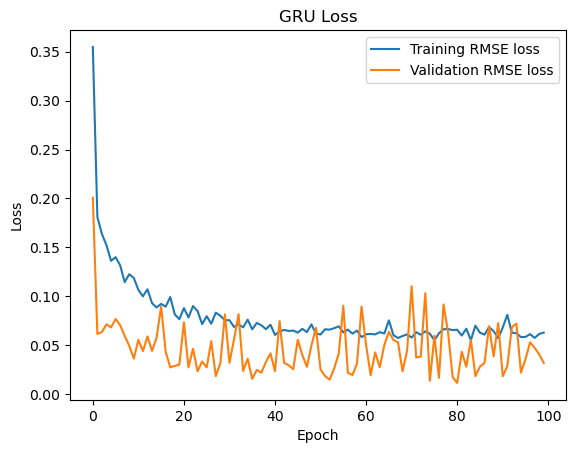

In [148]:
plt.plot(concatenated_df_gru['epoch'], concatenated_df_gru['GRU_TRAIN_RMSE'], label='Training RMSE loss')
plt.plot(concatenated_df_gru['epoch'], concatenated_df_gru['GRU_VAL_RMSE'], label='Validation RMSE loss')
plt.title('GRU Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch') 
plt.legend(loc='upper right')
plt.show()

### Model Comparison Based On Validation RMSE

In [149]:
merged_df = pd.merge(concatenated_df, concatenated_df_cnn, on='epoch', how='left', suffixes=('', '_cnn'))
final_merged_df = pd.merge(merged_df, concatenated_df_gru, on='epoch', how='left', suffixes=('', '_gru'))
final_merged_df=final_merged_df[['epoch','LSTM_VAL_RMSE','CNN_VAL_RMSE','GRU_VAL_RMSE']]
final_merged_df

,epoch,LSTM_VAL_RMSE,CNN_VAL_RMSE,GRU_VAL_RMSE
0,0,0.131828,0.141673,0.200743
1,1,0.113439,0.094715,0.061310
2,2,0.133723,0.139112,0.063390
3,3,0.120367,0.100490,0.071152
4,4,0.049808,0.164537,0.067997
...,...,...,...,...
95,95,0.047299,0.037415,0.035463
96,96,0.138343,0.060164,0.052758
97,97,0.036694,0.040516,0.047092
98,98,0.059484,0.034131,0.040469


In [150]:
lstm_rmse=final_merged_df['LSTM_VAL_RMSE'].mean()
gru_rmse=final_merged_df['GRU_VAL_RMSE'].mean()
cnn_rmse=final_merged_df['CNN_VAL_RMSE'].mean()

In [151]:
lstm_rmse

0.05276719089597463

In [152]:
gru_rmse

0.04600852466188371

In [153]:
cnn_rmse

0.05620614670217037

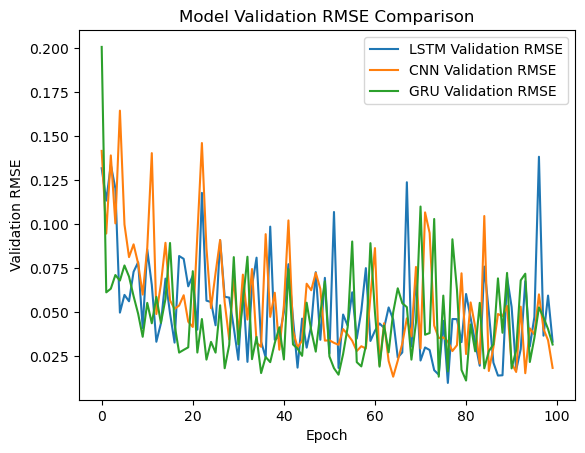

In [155]:
plt.plot(final_merged_df['epoch'], final_merged_df['LSTM_VAL_RMSE'], label='LSTM Validation RMSE')
plt.plot(final_merged_df['epoch'], final_merged_df['CNN_VAL_RMSE'], label='CNN Validation RMSE')
plt.plot(final_merged_df['epoch'], final_merged_df['GRU_VAL_RMSE'], label='GRU Validation RMSE')

plt.title('Model Validation RMSE Comparison')
plt.xlabel('Epoch')
plt.ylabel('Validation RMSE')
plt.legend()
plt.show()

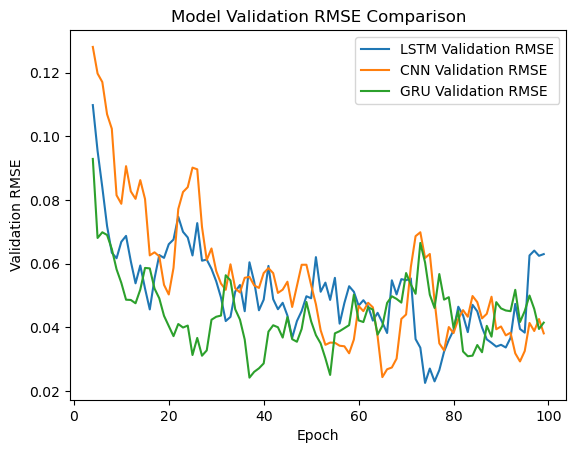

In [156]:
rolling_mean_df = final_merged_df.set_index('epoch').rolling(window=5).mean()
plt.plot(rolling_mean_df['LSTM_VAL_RMSE'], label='LSTM Validation RMSE')
plt.plot(rolling_mean_df['CNN_VAL_RMSE'], label='CNN Validation RMSE')
plt.plot(rolling_mean_df['GRU_VAL_RMSE'], label='GRU Validation RMSE')
plt.title('Model Validation RMSE Comparison')
plt.xlabel('Epoch')
plt.ylabel('Validation RMSE')
plt.legend()
plt.show()

In [157]:
final_merged_df.head()

,epoch,LSTM_VAL_RMSE,CNN_VAL_RMSE,GRU_VAL_RMSE
0,0,0.131828,0.141673,0.200743
1,1,0.113439,0.094715,0.061310
2,2,0.133723,0.139112,0.063390
3,3,0.120367,0.100490,0.071152
4,4,0.049808,0.164537,0.067997
